### aim: 

### date: 

In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [8]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [9]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

    co2 variable	co2 static
    clim var (aka dynamic)	(A)	(D)
    clim stat (aka bias)	(C)	(B)
    From Hauck 2020 (Frontiers):

    SOCEAN = Fant,ss + Fant,ns + Fnat,ns

    FsimA = Fant,ss + Fant,ns + Fnat,ss + Fnat,ns + Fdrift+bias

    FsimB = Fnat,ss + Fdrift+bias
    Fnat,ss is defined to be 0.

    it follows that:

    FsimC = Fant,ss + Fnat,ss + Fdrift+bias

    FsimD = Fnat,ns + Fnat,ss + Fdrift+bias
    If we want to partition SOCEAN into its components Fant,ss + Fant,ns + Fnat,ns,

    we can get:

    Fnat,ns = FsimD - FsimB
    Fant,ss = FsimC - FsimB
    Fant,ns = FsimA - FsimB - Fnat,ns - Fant,ss 

    SOCEAN = FsimA - FsimB
    or the sum of the above 3 terms.

    45 - hauck 2020 61 - gruber 2023

    X = C - B
    Z = D - B 
    Y = A - D - C + B
    S = X + Y + Z
    Sc = A - B
    #SOceancheck = Fnatns + Fantss + Fantns
    
    #     X = Fantss 
    #     Y = Fantns
    #     Z = FNatns
    #     W = FNatss
    #     R = drift


To plot: carbon flux
DIC accumulation (surface and depth-integrated?)


prov | low lat | indices
-- | -- | --
NAT | 0 | 73:90
NAL | 17.78 | 90:100
NAM | 35.56 | 100:109
NAH | 48.9 | 109:145



In [10]:
def make_yearlist(yrst, yrend, dtype, mod = 'RVA0'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/{mod}_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

A_ptrc = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc', 'RVA0'))
B_ptrc = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc', 'RVB0'))
C_ptrc = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc', 'RVC0'))
D_ptrc = xr.open_mfdataset(make_yearlist(1950,2020,'ptrc', 'RVD0'))


A_diad = xr.open_mfdataset(make_yearlist(1950,2020,'diad', 'RVA0'))
B_diad = xr.open_mfdataset(make_yearlist(1950,2020,'diad', 'RVB0'))
C_diad = xr.open_mfdataset(make_yearlist(1950,2020,'diad', 'RVC0'))
D_diad = xr.open_mfdataset(make_yearlist(1950,2020,'diad', 'RVD0'))

ATL (A-C) cflx vs amoc  0.3082783338181646 0.008908995229175222
ATL (D-B) cflx vs amoc 0.17511950731255596 0.1440962785483508
 - - - 
NAT (A-C) cflx vs amoc  0.19427194238796902 0.10450043472015332
NAT (D-B) cflx vs amoc 0.12245338126745284 0.30899613286562394
 - - - 
NAL (A-C) cflx vs amoc  0.10630142861672143 0.3776057111877186
NAL (D-B) cflx vs amoc 0.11888099636565319 0.3234289659337193
 - - - 
NAM (A-C) cflx vs amoc  -0.07214500214526307 0.5499105177740785
NAM (D-B) cflx vs amoc -0.21127563427785392 0.07694979197191289
 - - - 
NAH (A-C) cflx vs amoc  0.48783459328437717 1.594624578821635e-05
NAH (D-B) cflx vs amoc 0.31600622406922974 0.0072612149612344525
 - - - 


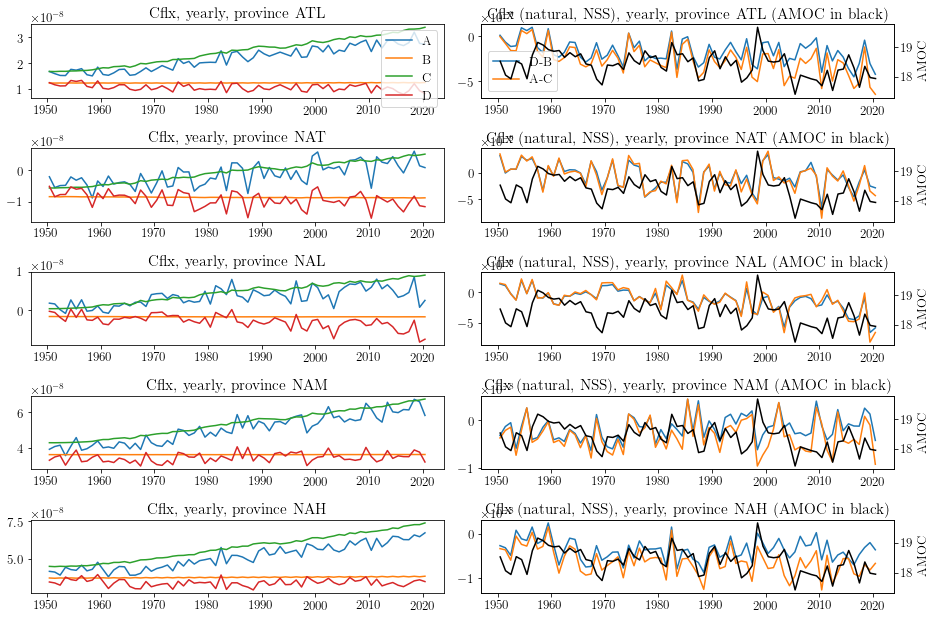

In [11]:
from scipy.stats import pearsonr

RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
RVA0_vyrez = RVA0_amoc.sel(TIME=slice(f'1950-01-01', f'2020-12-31'))

provs = ['ATL','NAT','NAL','NAM','NAH']


fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for p in range(0,5):
    tprov = provs[p]

    A_cflx = A_diad.regmeanf.sel(varf = 'Cflx').sel(prov = tprov)
    B_cflx = B_diad.regmeanf.sel(varf = 'Cflx').sel(prov = tprov)
    C_cflx = C_diad.regmeanf.sel(varf = 'Cflx').sel(prov = tprov)
    D_cflx = D_diad.regmeanf.sel(varf = 'Cflx').sel(prov = tprov)
    axs[p*2].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             A_cflx.groupby('time_counter.year').mean(), label = 'A')
    axs[p*2].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             B_cflx.groupby('time_counter.year').mean(), label = 'B')
    axs[p*2].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             C_cflx.groupby('time_counter.year').mean(), label = 'C')
    axs[p*2].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             D_cflx.groupby('time_counter.year').mean(), label = 'D')
    
    axs[p*2].set_title(F'Cflx, yearly, province {tprov}')
    axs[0].legend(loc = 'best')
    
    #D-B, C-A
    axs[p*2+1].plot(D_cflx.time_counter.groupby('time_counter.year').mean(), \
             (D_cflx.groupby('time_counter.year').mean() - B_cflx.groupby('time_counter.year').mean()),\
            label = 'D-B')
    axs[p*2+1].plot(D_cflx.time_counter.groupby('time_counter.year').mean(), \
         (A_cflx.groupby('time_counter.year').mean() - C_cflx.groupby('time_counter.year').mean()),\
        label = 'A-C')
    
    tval1 = (A_cflx.groupby('time_counter.year').mean() - C_cflx.groupby('time_counter.year').mean()).values
    tval2 = (D_cflx.groupby('time_counter.year').mean() - B_cflx.groupby('time_counter.year').mean()).values
    
    amoc = RVA0_vyrez.AMOC.groupby('TIME.year').mean()
    correlation_coefficient, pv = pearsonr(amoc, tval1)
    correlation_coefficient2, pv2 = pearsonr(amoc, tval2)
    print(f'{tprov} (A-C) cflx vs amoc  {correlation_coefficient} {pv}')
    print(f'{tprov} (D-B) cflx vs amoc {correlation_coefficient2} {pv2}')
    print(' - - - ')
    
    axb1 = axs[p*2+1]
    axb = axb1.twinx()
    axb.plot(RVA0_vyrez.TIME.groupby('TIME.year').mean(),\
             RVA0_vyrez.AMOC.groupby('TIME.year').mean(), 'k-', label = 'AMOC' )  # 'b-' means blue solid line
    axb.set_ylabel('AMOC', color='k')    
    axs[p*2+1].set_title(f'Cflx (natural, NSS), yearly, province {tprov} (AMOC in black)')
    
    
    axs[1].legend()

plt.tight_layout()

In [13]:
def make_yearlist_t(yrst, yrend, dtype, tr, bd):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/transports/{tr}_{yrs[i]}_{dtype}_row{bd}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

# RVA0_amoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/AMOC_TOM12_TJ_RVA0_1945-2022.nc')
# A_73 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVA0', bd = 73))
# B_73 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVB0', bd = 73))
# C_73 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVC0', bd = 73))
# D_73 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVD0', bd = 73))

# A_90 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVA0', bd = 90))
# B_90 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVB0', bd = 90))
# C_90 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVC0', bd = 90))
# D_90 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVD0', bd = 90))

# A_100 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVA0', bd = 100))
# B_100 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVB0', bd = 100))
# C_100 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVC0', bd = 100))
# D_100 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVD0', bd = 100))

# A_109 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVA0', bd = 109))
# B_109 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVB0', bd = 109))
# C_109 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVC0', bd = 109))
# D_109 = xr.open_mfdataset(make_yearlist_t(1950, 2021, 'DIC', 'RVD0', bd = 109))


# TNat_ns_90 = D_90 - B_90
# TAnt_ss_90 = C_90 - B_90
# Tant_ns_90 = A_90 - B_90 - TNat_ns_90 - TAnt_ss_90


## correlations between the various transports and AMOC.. 

i calculated these in /gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/data/extract/correlate-dic.py

In [16]:
sh = False
if sh:
    fact = 1.1
    fig, axs = plt.subplots(3,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    TNat_ns_90 = D_90 - B_90
    TAnt_ss_90 = C_90 - B_90
    Tant_ns_90 = A_90 - B_90 - TNat_ns_90 - TAnt_ss_90

    amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31'))

    for i in range(0,31):
        axs[0].plot(TNat_ns_90.time_counter.groupby('time_counter.year').mean(), \
                 TNat_ns_90.tracer_transports.isel(depthlevel = i).sel(type = 'net').\
                    groupby('time_counter.year').mean(), label = 'TNAT_NAL')
        variable = TNat_ns_90.tracer_transports.sel(time_counter=slice(f'{1950}-01-01', f'{2020}-12-31')).\
        isel(depthlevel = i).sel(type = 'net').groupby('time_counter.year').mean()
        amoc = RVA0_amoc.AMOC.sel(TIME=slice(f'{1950}-01-01', f'{2020}-12-31')).groupby('TIME.year').mean()
        correlation_coefficient, p = pearsonr(amoc, variable)
        if p > 0.05:
            correlation_coefficient = 0
        print(f'{i} {correlation_coefficient} {p}')

Southern ocean sink 

    X = Fantss 
    Y = Fantns
    Z = FNatns
    W = FNatss
    R = drift

    FsimA = Fant,ss + Fant,ns + Fnat,ss + Fnat,ns + Fdrift+bias
    A = X + Y + Z + W + R
    
    FsimB = Fnat,ss + Fdrift+bias
    B = W + R
    
    W (Fnat,ss) is defined to be 0.
    it follows that:

    FsimC = Fant,ss + Fnat,ss + Fdrift+bias
    C = X + W + R
    
    FsimD = Fnat,ns + Fnat,ss + Fdrift+bias
    D = Z + X + W + R
    

    X = C - B
    Z = D - B 
    Y = A - D - C + B
    S = X + Y + Z
    Sc = A - B
    #SOceancheck = Fnatns + Fantss + Fantns
    
    #     X = Fantss 
    #     Y = Fantns
    #     Z = FNatns
    #     W = FNatss
    #     R = drift
    

ATL, 0.49479267678710936, 1.1536215793499236e-05
NAT, 0.37024381479426605, 0.0014823769667484284
NAL, 0.3057286904266112, 0.009520052096766075
NAM, 0.20742418644508298, 0.08261764355405726
NAH, 0.25090285401840584, 0.03481480139551772


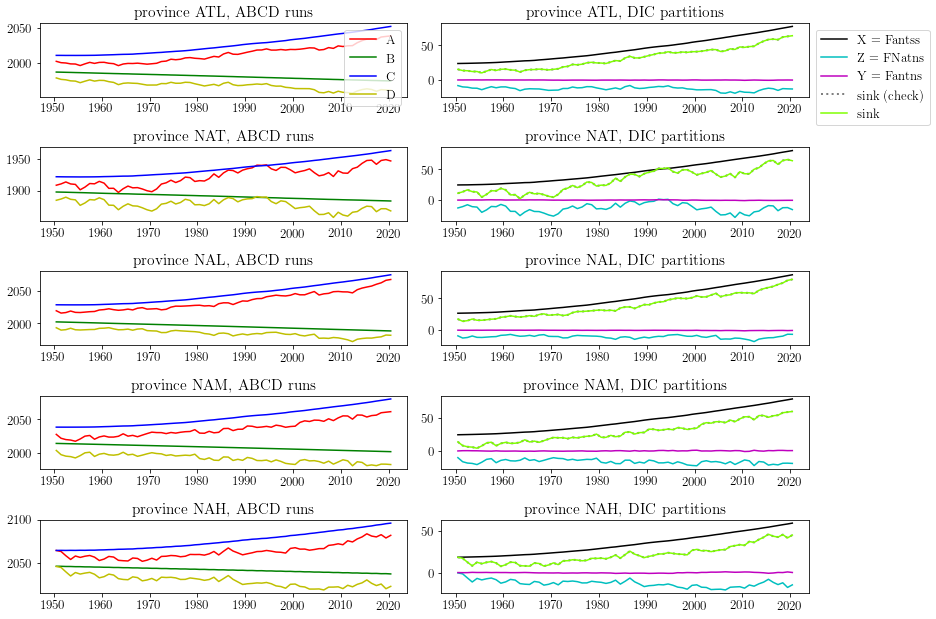

In [48]:
tf = 1e6

A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = 'ATL')

fact = 1.1
fig, axs = plt.subplots(5,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for p in range(0,5):
    tprov = provs[p]

    A = A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    B = B_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    C = C_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    D = D_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    axs[p*2].plot(A.time_counter.groupby('time_counter.year').mean(), \
             A.regmean.groupby('time_counter.year').mean(), label = 'A', color = 'r')
    axs[p*2].plot(A.time_counter.groupby('time_counter.year').mean(), \
             B.regmean.groupby('time_counter.year').mean(), label = 'B', color = 'g')
    axs[p*2].plot(A.time_counter.groupby('time_counter.year').mean(), \
             C.regmean.groupby('time_counter.year').mean(), label = 'C', color = 'b')
    axs[p*2].plot(A.time_counter.groupby('time_counter.year').mean(), \
             D.regmean.groupby('time_counter.year').mean(), label = 'D', color = 'y')
    axs[p*2].set_title(f'province {tprov}, ABCD runs')
    
    X = C - B
    Z = D - B 
    Y = A - D - C + B
    S = X + Y + Z
    Sc = A - B
    #SOceancheck = Fnatns + Fantss + Fantns
    
#     X = Fantss 
#     Y = Fantns
#     Z = FNatns
#     W = FNatss
#     R = drift
    
    axs[p*2+1].plot(A.time_counter.groupby('time_counter.year').mean(), \
             X.regmean.groupby('time_counter.year').mean(), label = 'X = Fantss', color = 'k')
    axs[p*2+1].plot(A.time_counter.groupby('time_counter.year').mean(), \
             Z.regmean.groupby('time_counter.year').mean(), label = 'Z = FNatns', color = 'c')
    correlation_coefficient, pk = pearsonr(amoc,  Z.regmean.groupby('time_counter.year').mean())
    print(f'{tprov}, {correlation_coefficient}, {pk}')
    axs[p*2+1].plot(A.time_counter.groupby('time_counter.year').mean(), \
             Y.regmean.groupby('time_counter.year').mean(), label = 'Y = Fantns', color = 'm')
    axs[p*2+1].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             S.regmean.groupby('time_counter.year').mean(), label = 'sink (check)', color = 'grey', linestyle = ':', linewidth = 2)
    axs[p*2+1].plot(A_cflx.time_counter.groupby('time_counter.year').mean(), \
             Sc.regmean.groupby('time_counter.year').mean(), label = 'sink', color = 'chartreuse')
    axs[p*2+1].set_title(f'province {tprov}, DIC partitions')
    
axs[0].legend()
axs[1].legend(bbox_to_anchor = [1,1])
plt.tight_layout()

ATL, 0.49479267678710936, 1.1536215793499236e-05
NAT, 0.37024381479426605, 0.0014823769667484284
NAL, 0.3057286904266112, 0.009520052096766075
NAM, 0.20742418644508298, 0.08261764355405726
NAH, 0.25090285401840584, 0.03481480139551772


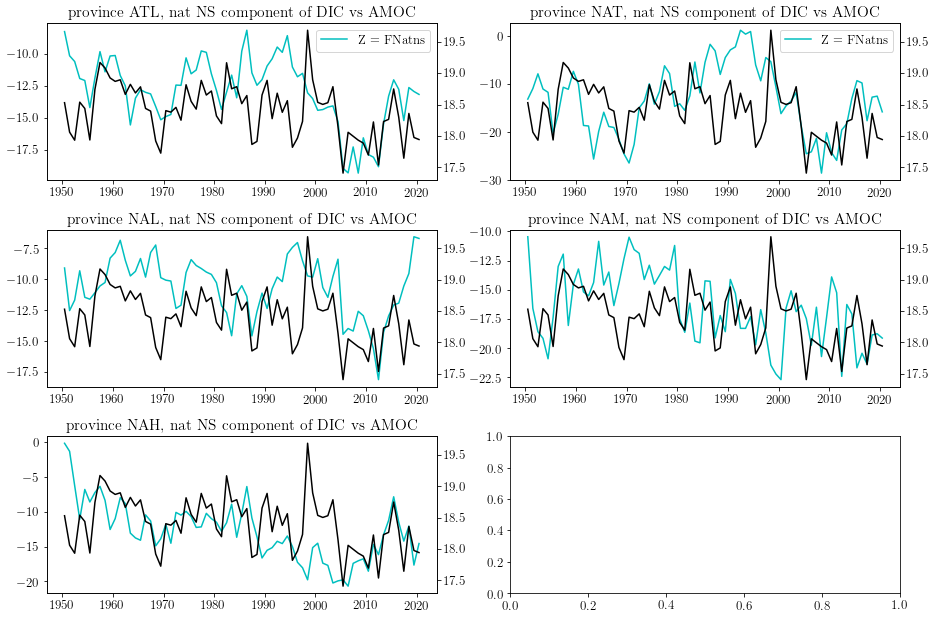

In [51]:
tf = 1e6

A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = 'ATL')

fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for p in range(0,5):
    tprov = provs[p]

    A = A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    B = B_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    C = C_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    D = D_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf

    X = C - B
    Z = D - B 
    Y = A - D - C + B
    S = X + Y + Z
    Sc = A - B
    #SOceancheck = Fnatns + Fantss + Fantns
    
#     X = Fantss 
#     Y = Fantns
#     Z = FNatns
#     W = FNatss
#     R = drift
    

    axs[p].plot(A.time_counter.groupby('time_counter.year').mean(), \
             Z.regmean.groupby('time_counter.year').mean(), label = 'Z = FNatns', color = 'c')
    correlation_coefficient, pk = pearsonr(amoc,  Z.regmean.groupby('time_counter.year').mean())
    print(f'{tprov}, {correlation_coefficient}, {pk}')
    ax2 = axs[p].twinx()
    ax2.plot(A.time_counter.groupby('time_counter.year').mean(),amoc, color = 'k')
    
    axs[p].set_title(f'province {tprov}, nat NS component of DIC vs AMOC')
    
axs[0].legend()
axs[1].legend(bbox_to_anchor = [1,1])
plt.tight_layout()

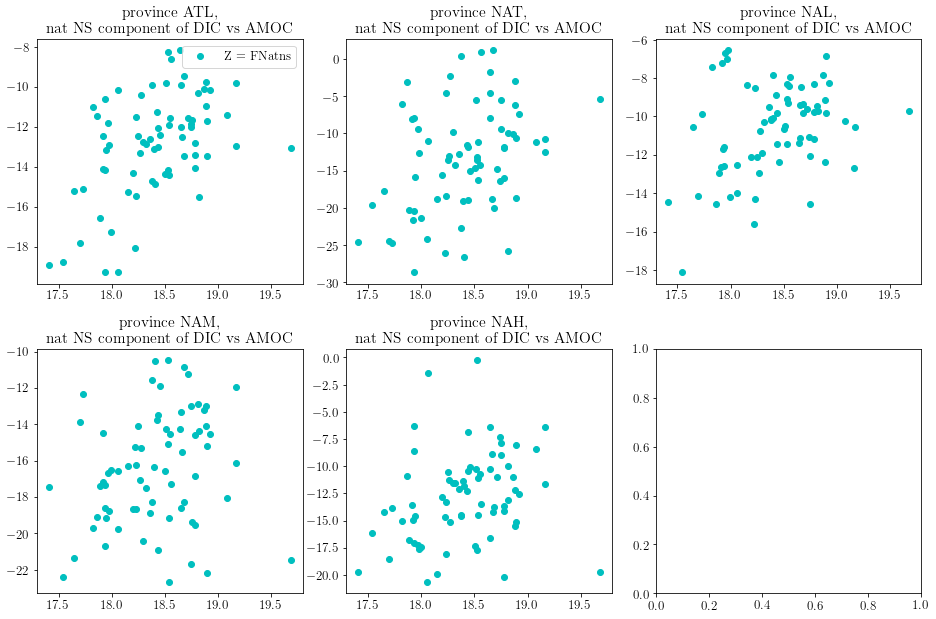

In [54]:
tf = 1e6

A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = 'ATL')

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for p in range(0,5):
    tprov = provs[p]

    A = A_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    B = B_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    C = C_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf
    D = D_ptrc.sel(var = 'DIC').isel(deptht = 0).sel(prov = tprov)*tf

    X = C - B
    Z = D - B 
    Y = A - D - C + B
    S = X + Y + Z
    Sc = A - B
    #SOceancheck = Fnatns + Fantss + Fantns
    
#     X = Fantss 
#     Y = Fantns
#     Z = FNatns
#     W = FNatss
#     R = drift
    

    axs[p].scatter(amoc, \
             Z.regmean.groupby('time_counter.year').mean(), label = 'Z = FNatns', color = 'c')
    correlation_coefficient, pk = pearsonr(amoc,  Z.regmean.groupby('time_counter.year').mean())
    
    axs[p].set_title(f'province {tprov}, \n nat NS component of DIC vs AMOC')
    
axs[0].legend()
#axs[1].legend(bbox_to_anchor = [1,1])
plt.tight_layout()

## transports 

Text(0.5, 1.0, 'TNAT_ns northward transport and amoc corellation')

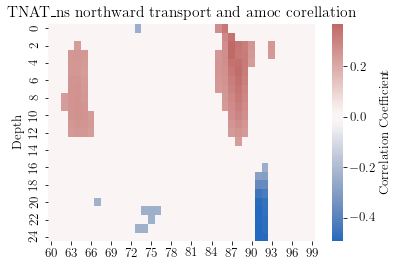

In [65]:
# TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TAnt_ss_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv

import seaborn as sns

net_DIC1 = pd.read_csv('./transports/TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv', index_col='Depth')
net_DIC2 = pd.read_csv('./transports/TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r70_r80.csv', index_col='Depth')
net_DIC3 = pd.read_csv('./transports/TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r80_r90.csv', index_col='Depth')
net_DIC4 = pd.read_csv('./transports/TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r90_r100.csv', index_col='Depth')


net_DIC = pd.concat([net_DIC1, net_DIC2, net_DIC3, net_DIC4], axis=1)


fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')

sns.heatmap(net_DIC, annot=False, cmap='vlag', center=0, \
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs)
plt.title('TNAT_ns northward transport and amoc corellation')


<AxesSubplot:ylabel='Depth'>

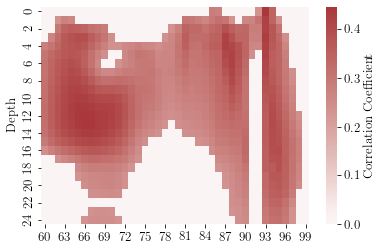

In [63]:
# TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TAnt_ss_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv

import seaborn as sns

net_DIC1 = pd.read_csv('./transports/TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv', index_col='Depth')
net_DIC2 = pd.read_csv('./transports/TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r70_r80.csv', index_col='Depth')
net_DIC3 = pd.read_csv('./transports/TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r80_r90.csv', index_col='Depth')
net_DIC4 = pd.read_csv('./transports/TAnt_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r90_r100.csv', index_col='Depth')


net_DIC = pd.concat([net_DIC1, net_DIC2, net_DIC3, net_DIC4], axis=1)


fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')

sns.heatmap(net_DIC, annot=False, cmap='vlag', center=0, \
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs)



<AxesSubplot:ylabel='Depth'>

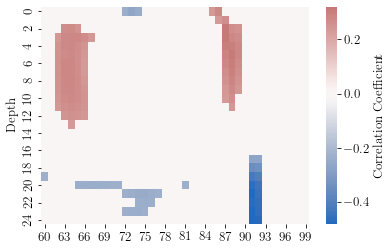

In [64]:
# TNat_ns_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TAnt_ss_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv
# TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv

import seaborn as sns

net_DIC1 = pd.read_csv('./transports/TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r60_r70.csv', index_col='Depth')
net_DIC2 = pd.read_csv('./transports/TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r70_r80.csv', index_col='Depth')
net_DIC3 = pd.read_csv('./transports/TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r80_r90.csv', index_col='Depth')
net_DIC4 = pd.read_csv('./transports/TTot_net_DIC_transport_vs_amoc_1950_2020_annual_r90_r100.csv', index_col='Depth')


net_DIC = pd.concat([net_DIC1, net_DIC2, net_DIC3, net_DIC4], axis=1)


fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')

sns.heatmap(net_DIC, annot=False, cmap='vlag', center=0, \
            cbar_kws={'label': 'Correlation Coefficient'}, ax = axs)

